In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir

In [2]:

def crop_brain_contour(image, plot=False):
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

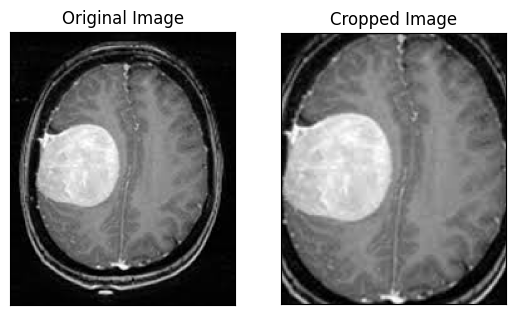

In [3]:

ex_img = cv2.imread('C:\study materials/UNI/project/8th sem/try/New_Yes/Y1.jpg')
ex_new_img = crop_brain_contour(ex_img, True)

In [4]:

def load_data(dir_list, image_size):

    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            image = cv2.imread(directory + '\\' + filename)
            image = crop_brain_contour(image, plot=False)
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            image = image / 255.
            X.append(image)
            if directory[-3:] == 'Yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

In [5]:
new_path = 'C:\study materials/UNI/project/8th sem/try/'

New_yes = new_path + 'New_Yes' 
New_no = new_path + 'New_No'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([New_yes, New_no], (IMG_WIDTH, IMG_HEIGHT))


Number of examples is: 4015
X shape is: (4015, 240, 240, 3)
y shape is: (4015, 1)


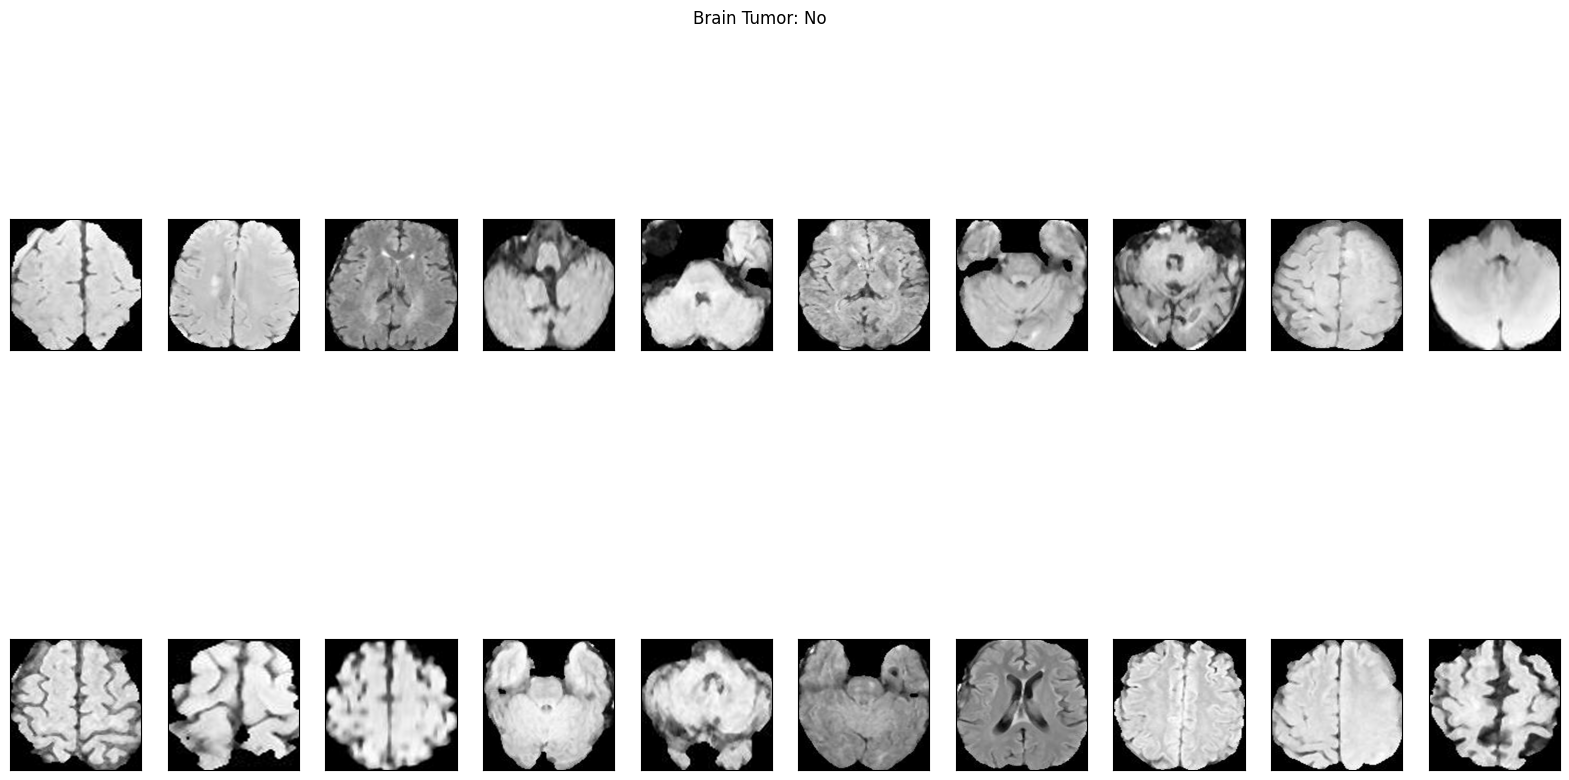

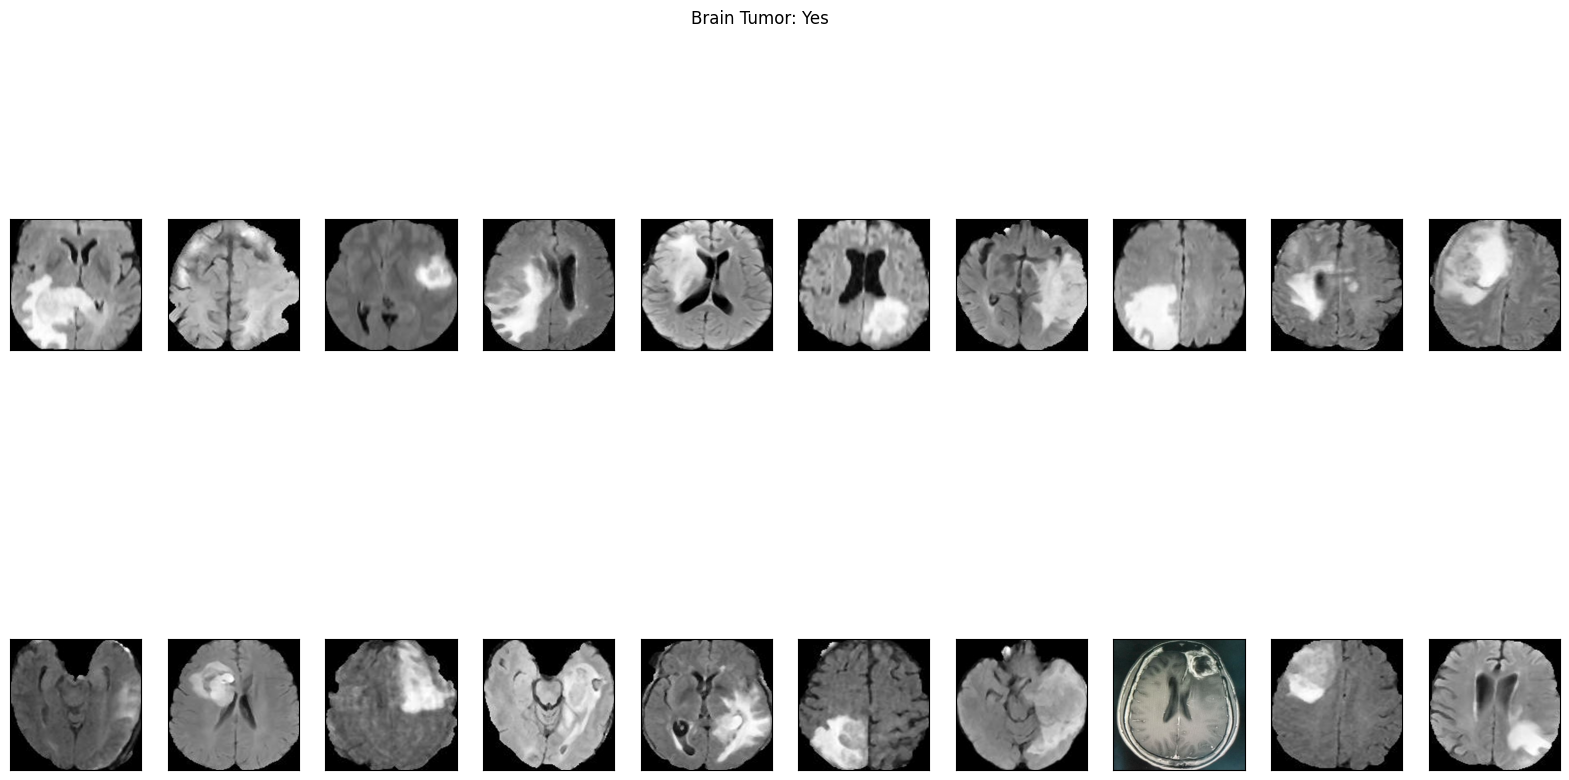

In [6]:

def plot_sample_images(X, y, n=20):
    
    for label in [0,1]:
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))
        
        i = 1      
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

plot_sample_images(X, y)

In [7]:

def split_data(X, y, test_size=0.2):
       
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test


X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [8]:

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 2810
number of development examples = 603
number of test examples = 602
X_train shape: (2810, 240, 240, 3)
Y_train shape: (2810, 1)
X_val (dev) shape: (603, 240, 240, 3)
Y_val (dev) shape: (603, 1)
X_test shape: (602, 240, 240, 3)
Y_test shape: (602, 1)


In [9]:

def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

In [10]:
def compute_f1_score(y_true, prob):

    y_pred = np.where(prob > 0.5, 1, 0)
    
    score = f1_score(y_true, y_pred)
    
    return score

In [11]:
def build_model(input_shape):

    
    X_input = Input(input_shape)
    
    
    X = ZeroPadding2D((2, 2))(X_input)
    
    
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X)
    
    
    X = MaxPooling2D((4, 4), name='max_pool0')(X)
    
    
    X = MaxPooling2D((4, 4), name='max_pool1')(X)
    
    
    X = Flatten()(X)
    
    X = Dense(1, activation='sigmoid', name='fc')(X)
    
    
    model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')
    
    return model

In [12]:

IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)
model = build_model(IMG_SHAPE)
model.summary()

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


log_file_name = f'brain_tumor_detection_cnn_{int(time.time())}'
tensorboard = TensorBoard(log_dir=f'logs/{log_file_name}')



filepath="cnn-parameters-improvement-{epoch:02d}-{val_accuracy:.2f}"

checkpoint = ModelCheckpoint("models/{}.keras".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max'))

Model: "BrainDetectionModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 240, 240, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d (ZeroPadding2D)  │ (None, 244, 244, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv0 (Conv2D)                  │ (None, 238, 238, 32)   │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn0 (BatchNormalization)        │ (None, 238, 238, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 238, 238, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool0 (MaxPooling2D)        │ (None, 59, 59, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool1 (MaxPooling2D)        │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc (Dense)                      │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,137 (43.50 KB)

 Trainable params: 11,073 (43.25 KB)

 Non-trainable params: 64 (256.00 B)

In [13]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 53s 586ms/step - accuracy: 0.6720 - loss: 0.8328 - val_accuracy: 0.5423 - val_loss: 0.8742
Epoch 2/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 51s 582ms/step - accuracy: 0.8441 - loss: 0.3818 - val_accuracy: 0.8375 - val_loss: 0.3782
Epoch 3/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 51s 577ms/step - accuracy: 0.8560 - loss: 0.3387 - val_accuracy: 0.8159 - val_loss: 0.4030
Epoch 4/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 51s 578ms/step - accuracy: 0.8736 - loss: 0.3068 - val_accuracy: 0.8988 - val_loss: 0.2855
Epoch 5/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 83s 591ms/step - accuracy: 0.8758 - loss: 0.2892 - val_accuracy: 0.7778 - val_loss: 0.6095
Epoch 6/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 52s 591ms/step - accuracy: 0.8699 - loss: 0.3078 - val_accuracy: 0.9088 - val_loss: 0.2700
Epoch 7/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 51s 575ms/step - accuracy: 0.9020 - loss: 0.2610 - val_accuracy: 0.8839 - val_loss: 0.2733
Epoch 8/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 51s 576ms/step - accuracy: 0.8816 - loss: 0.2769 - val_accu

In [14]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
88/88 ━━━━━━━━━━━━━━━━━━━━ 51s 583ms/step - accuracy: 0.9170 - loss: 0.2102 - val_accuracy: 0.9022 - val_loss: 0.2722
Epoch 2/3
88/88 ━━━━━━━━━━━━━━━━━━━━ 51s 576ms/step - accuracy: 0.9107 - loss: 0.2178 - val_accuracy: 0.8939 - val_loss: 0.2783
Epoch 3/3
88/88 ━━━━━━━━━━━━━━━━━━━━ 51s 580ms/step - accuracy: 0.9242 - loss: 0.2002 - val_accuracy: 0.9005 - val_loss: 0.2728
Elapsed time: 0:2:35.7


In [15]:

start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
88/88 ━━━━━━━━━━━━━━━━━━━━ 51s 581ms/step - accuracy: 0.9128 - loss: 0.2116 - val_accuracy: 0.8806 - val_loss: 0.2976
Epoch 2/3
88/88 ━━━━━━━━━━━━━━━━━━━━ 51s 577ms/step - accuracy: 0.9124 - loss: 0.2155 - val_accuracy: 0.8872 - val_loss: 0.3047
Epoch 3/3
88/88 ━━━━━━━━━━━━━━━━━━━━ 51s 576ms/step - accuracy: 0.9203 - loss: 0.2069 - val_accuracy: 0.8126 - val_loss: 0.4253
Elapsed time: 0:2:34.2


In [16]:

start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
88/88 ━━━━━━━━━━━━━━━━━━━━ 51s 581ms/step - accuracy: 0.9235 - loss: 0.1917 - val_accuracy: 0.9104 - val_loss: 0.2548
Epoch 2/3
88/88 ━━━━━━━━━━━━━━━━━━━━ 51s 575ms/step - accuracy: 0.9346 - loss: 0.1611 - val_accuracy: 0.7430 - val_loss: 0.9286
Epoch 3/3
88/88 ━━━━━━━━━━━━━━━━━━━━ 51s 574ms/step - accuracy: 0.9073 - loss: 0.2244 - val_accuracy: 0.8955 - val_loss: 0.3025
Elapsed time: 0:2:33.6


In [17]:

start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=5, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 51s 583ms/step - accuracy: 0.9414 - loss: 0.1613 - val_accuracy: 0.9121 - val_loss: 0.2550
Epoch 2/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 51s 577ms/step - accuracy: 0.9218 - loss: 0.1923 - val_accuracy: 0.9154 - val_loss: 0.2554
Epoch 3/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 51s 576ms/step - accuracy: 0.9518 - loss: 0.1374 - val_accuracy: 0.9154 - val_loss: 0.2591
Epoch 4/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 51s 583ms/step - accuracy: 0.9478 - loss: 0.1507 - val_accuracy: 0.9187 - val_loss: 0.2682
Epoch 5/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 51s 577ms/step - accuracy: 0.9506 - loss: 0.1418 - val_accuracy: 0.9138 - val_loss: 0.2845
Elapsed time: 0:4:16.4


In [18]:

history = model.history.history


for key in history.keys():
    print(key)


accuracy
loss
val_accuracy
val_loss


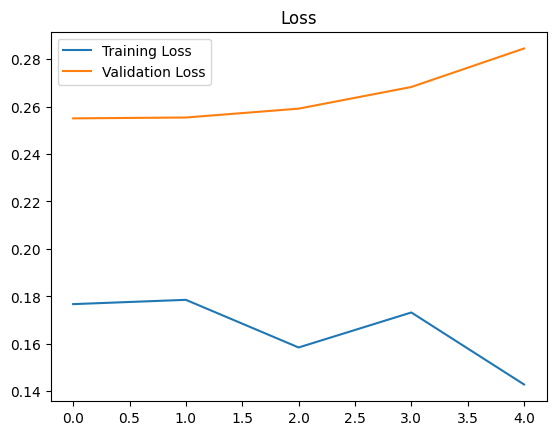

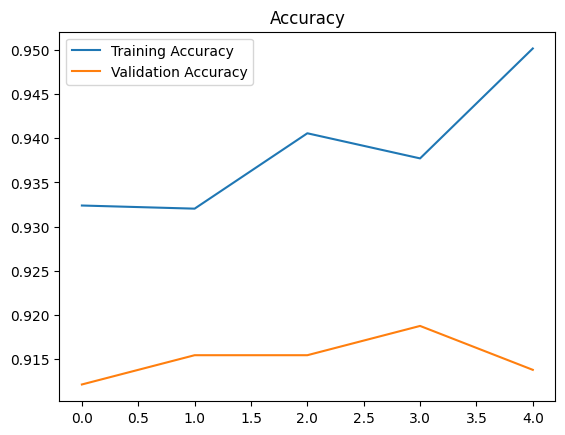

In [19]:

def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    

    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    

    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()
    
plot_metrics(history)

In [21]:

best_model = load_model(filepath='C:\study materials/UNI/project/8th sem/try/models/cnn-parameters-improvement-03-0.92.keras')
best_model.metrics_names
loss, acc = best_model.evaluate(x=X_test, y=y_test)
print (f"Test Loss = {loss}")
print (f"Test Accuracy = {acc}")
y_test_prob = best_model.predict(X_test)
f1score = compute_f1_score(y_test, y_test_prob)
print(f"F1 score: {f1score}")
y_val_prob = best_model.predict(X_val)
f1score_val = compute_f1_score(y_val, y_val_prob)
print(f"F1 score: {f1score_val}")








def data_percentage(y):
    
    m=len(y)
    n_positive = np.sum(y)
    n_negative = m - n_positive
    
    pos_prec = (n_positive* 100.0)/ m
    neg_prec = (n_negative* 100.0)/ m
    
    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {n_positive}") 
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {n_negative}") 


data_percentage(y)

print("Training Data:")
data_percentage(y_train)
print("Validation Data:")
data_percentage(y_val)
print("Testing Data:")
data_percentage(y_test)

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.9020 - loss: 0.2616
Test Loss = 0.25922101736068726
Test Accuracy = 0.9069767594337463
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step
F1 score: 0.8893280632411067
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step
F1 score: 0.9057301293900185
Number of examples: 4015
Percentage of positive examples: 45.778331257783314%, number of pos examples: 1838
Percentage of negative examples: 54.221668742216686%, number of neg examples: 2177
Training Data:
Number of examples: 2810
Percentage of positive examples: 46.08540925266904%, number of pos examples: 1295
Percentage of negative examples: 53.91459074733096%, number of neg examples: 1515
Validation Data:
Number of examples: 603
Percentage of positive examples: 46.26865671641791%, number of pos examples: 279
Percentage of negative examples: 53.73134328358209%, number of neg examples: 324
Testing Data:
Number of examples: 602
Percentage of positive examples: 43.85382059800664%, number of pos examples: 264
Perc